# ComputeIoU Demo - Interactive Examples

This notebook demonstrates the `computeIoU` method from `COCOeval` using mock data.
We'll explore different scenarios:
1. Perfect match (IoU = 1.0)
2. Partial overlap (IoU ~ 0.5)
3. No overlap (IoU = 0.0)
4. Multiple predictions vs ground truths
5. Visualizations of bounding boxes and segmentation masks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import numpy as np
import json
import tempfile
import os

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Reload modules to get the latest fixes
import sys
import importlib

# Remove cached modules
if 'pycocotools.cocoeval' in sys.modules:
    del sys.modules['pycocotools.cocoeval']
if 'pycocotools.coco' in sys.modules:
    del sys.modules['pycocotools.coco']
if 'pycocotools' in sys.modules:
    del sys.modules['pycocotools']

print("✓ Modules cleared from cache")

✓ Modules cleared from cache


## Helper Functions for Visualization

In [3]:
def visualize_bboxes(gt_boxes, dt_boxes, title="Bounding Box Comparison", img_size=(640, 480)):
    """
    Visualize ground truth and detection bounding boxes.
    
    Args:
        gt_boxes: List of ground truth boxes in COCO format [x, y, w, h]
        dt_boxes: List of detection boxes in COCO format [x, y, w, h]
        title: Plot title
        img_size: Image dimensions (width, height)
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Draw ground truth boxes in green
    for i, box in enumerate(gt_boxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                                 edgecolor='green', facecolor='none', 
                                 label=f'GT {i+1}' if i == 0 else '')
        ax.add_patch(rect)
        ax.text(x, y-5, f'GT{i+1}', color='green', fontweight='bold', fontsize=12)
    
    # Draw detection boxes in red
    for i, box in enumerate(dt_boxes):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                                 edgecolor='red', facecolor='none', 
                                 linestyle='--',
                                 label=f'Pred {i+1}' if i == 0 else '')
        ax.add_patch(rect)
        ax.text(x+w, y-5, f'Pred{i+1}', color='red', fontweight='bold', fontsize=12)
    
    ax.set_xlim(0, img_size[0])
    ax.set_ylim(img_size[1], 0)  # Invert y-axis for image coordinates
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_masks(gt_masks, dt_masks, title="Segmentation Mask Comparison", img_size=(640, 480)):
    """
    Visualize ground truth and detection segmentation masks.
    
    Args:
        gt_masks: List of ground truth RLE masks
        dt_masks: List of detection RLE masks
        title: Plot title
        img_size: Image dimensions (width, height)
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Decode masks
    gt_combined = np.zeros(img_size[::-1], dtype=np.uint8)
    dt_combined = np.zeros(img_size[::-1], dtype=np.uint8)
    
    for i, mask_rle in enumerate(gt_masks):
        mask = maskUtils.decode(mask_rle)
        gt_combined[mask > 0] = (i + 1) * 50
    
    for i, mask_rle in enumerate(dt_masks):
        mask = maskUtils.decode(mask_rle)
        dt_combined[mask > 0] = (i + 1) * 50
    
    # Ground truth
    axes[0].imshow(gt_combined, cmap='Greens', alpha=0.7)
    axes[0].set_title('Ground Truth Masks', fontweight='bold')
    axes[0].axis('off')
    
    # Predictions
    axes[1].imshow(dt_combined, cmap='Reds', alpha=0.7)
    axes[1].set_title('Predicted Masks', fontweight='bold')
    axes[1].axis('off')
    
    # Overlap
    overlap = np.zeros((*img_size[::-1], 3), dtype=np.uint8)
    overlap[gt_combined > 0] = [0, 255, 0]  # Green for GT
    overlap[dt_combined > 0] = [255, 0, 0]  # Red for predictions
    overlap[(gt_combined > 0) & (dt_combined > 0)] = [255, 255, 0]  # Yellow for overlap
    
    axes[2].imshow(overlap)
    axes[2].set_title('Overlap (Yellow = Match)', fontweight='bold')
    axes[2].axis('off')
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_iou_matrix(ious, gt_labels=None, dt_labels=None):
    """
    Print IoU matrix in a formatted way.
    """
    if len(ious) == 0:
        print("No IoU values (empty arrays)")
        return
    
    print("\nIoU Matrix:")
    print("=" * 50)
    
    # If no labels provided, generate default labels for ground truths and predictions
    # gt_labels: column headers for the IoU matrix (one per ground truth)
    # dt_labels: row headers for the IoU matrix (one per detection/prediction)
    if gt_labels is None:
        gt_labels = [f"GT{i+1}" for i in range(ious.shape[1])]
    if dt_labels is None:
        dt_labels = [f"Pred{i+1}" for i in range(ious.shape[0])]
    
    # Header
    print(f"{'':8}", end="")
    for label in gt_labels:
        print(f"{label:>10}", end="")
    print()
    print("-" * (8 + 10 * len(gt_labels)))
    
    # Rows
    for i, dt_label in enumerate(dt_labels):
        print(f"{dt_label:8}", end="")
        for j in range(len(gt_labels)):
            print(f"{ious[i, j]:10.3f}", end="")
        print()
    print("=" * 50)

## Helper Function to Create Mock COCO Data

In [4]:
def create_mock_coco_data(gt_annotations, dt_annotations, img_size=(640, 480)):
    """
    Create mock COCO dataset and result files for testing.
    
    Args:
        gt_annotations: List of ground truth annotation dicts
        dt_annotations: List of detection annotation dicts
        img_size: Image dimensions (width, height)
    
    Returns:
        cocoGt, cocoDt: COCO objects for ground truth and detections
    """
    # Create ground truth dataset
    gt_dataset = {
        "info": {"description": "Mock COCO Dataset for IoU Demo"},
        "images": [
            {
                "id": 1,
                "width": img_size[0],
                "height": img_size[1],
                "file_name": "mock_image_001.jpg"
            }
        ],
        "categories": [
            {"id": 1, "name": "object", "supercategory": "thing"}
        ],
        "annotations": gt_annotations
    }
    
    # Save to temporary files
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
        json.dump(gt_dataset, f)
        gt_file = f.name
    
    with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
        json.dump(dt_annotations, f)
        dt_file = f.name
    
    # Create COCO objects
    cocoGt = COCO(gt_file)
    cocoDt = cocoGt.loadRes(dt_file)
    
    # Clean up temp files
    os.unlink(gt_file)
    os.unlink(dt_file)
    
    return cocoGt, cocoDt

## Example 1: Perfect Match (IoU = 1.0)

When a prediction perfectly overlaps with the ground truth, IoU = 1.0

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 1: PERFECT MATCH

Ground Truth Box: [x=100, y=100, w=200, h=150]
Prediction Box:   [x=100, y=100, w=200, h=150]

IoU Matrix:
               GT1
------------------
Pred1        1.000

✓ Perfect overlap results in IoU = 1.0


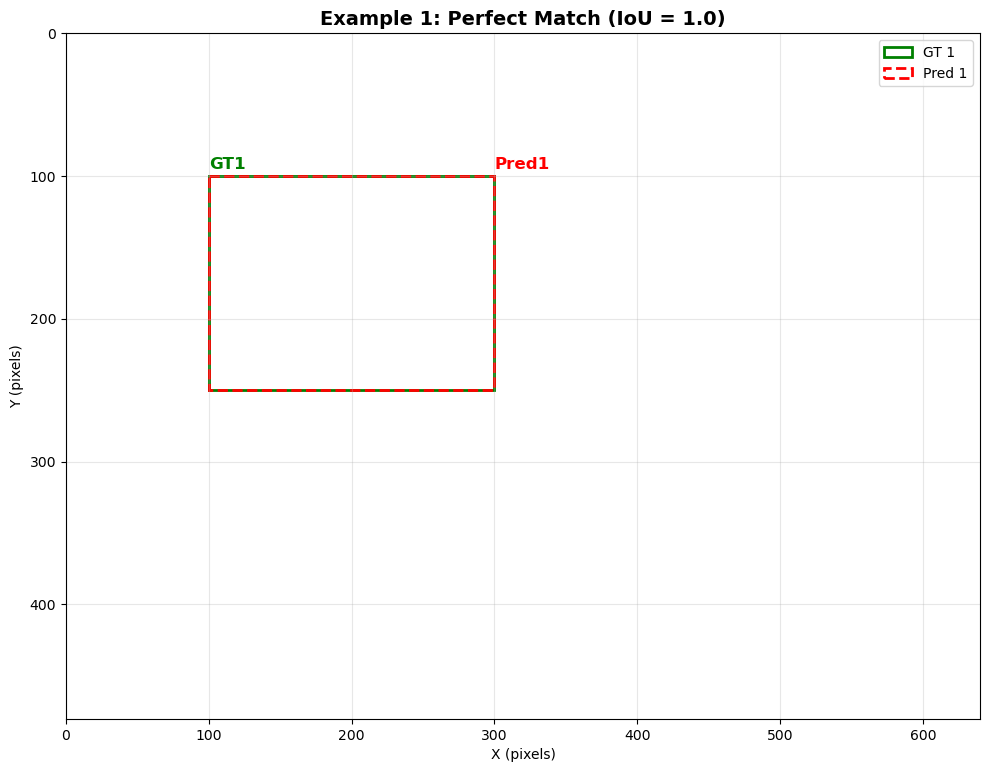

In [5]:
# Create annotations with perfect match
gt_anns_perfect = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 200, 150],  # [x, y, width, height]
        "area": 200 * 150,
        "iscrowd": 0
    }
]

dt_anns_perfect = [
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 200, 150],  # Same as GT
        "score": 0.95,
        "area": 200 * 150
    }
]

# Create COCO objects
cocoGt_perfect, cocoDt_perfect = create_mock_coco_data(gt_anns_perfect, dt_anns_perfect)

# Create COCOeval object
cocoEval_perfect = COCOeval(cocoGt_perfect, cocoDt_perfect, iouType='bbox')
cocoEval_perfect.params.imgIds = [1]
cocoEval_perfect.params.catIds = [1]
cocoEval_perfect._prepare()

# Compute IoU
ious_perfect = cocoEval_perfect.computeIoU(imgId=1, catId=1)

print("\n" + "="*60)
print("EXAMPLE 1: PERFECT MATCH")
print("="*60)
print("\nGround Truth Box: [x=100, y=100, w=200, h=150]")
print("Prediction Box:   [x=100, y=100, w=200, h=150]")
print_iou_matrix(ious_perfect)
print("\n✓ Perfect overlap results in IoU = 1.0")

# Visualize
visualize_bboxes(
    gt_boxes=[[100, 100, 200, 150]],
    dt_boxes=[[100, 100, 200, 150]],
    title="Example 1: Perfect Match (IoU = 1.0)"
)

## Example 2: Partial Overlap (IoU ≈ 0.5)

When prediction partially overlaps with ground truth

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 2: PARTIAL OVERLAP

Ground Truth Box: [x=100, y=100, w=200, h=150]
Prediction Box:   [x=150, y=125, w=200, h=150]

IoU Matrix:
               GT1
------------------
Pred1        0.455

✓ Partial overlap results in IoU ≈ 0.455


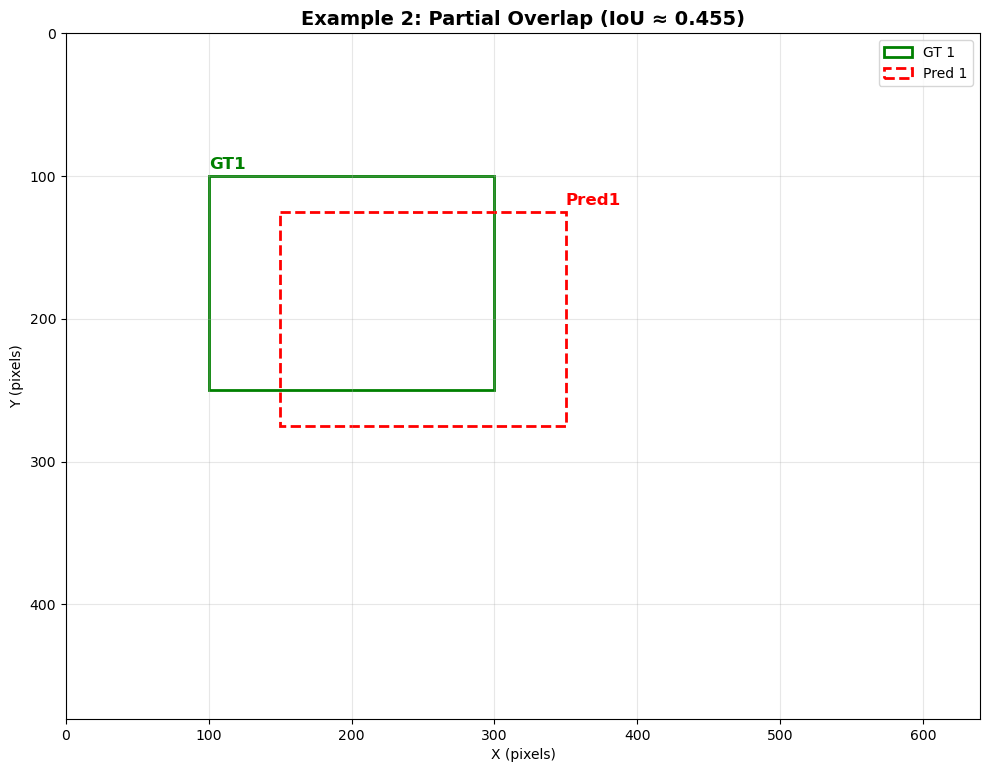

In [6]:
# Create annotations with partial overlap
gt_anns_partial = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 200, 150],
        "area": 200 * 150,
        "iscrowd": 0
    }
]

dt_anns_partial = [
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [150, 125, 200, 150],  # Shifted right and down
        "score": 0.85,
        "area": 200 * 150
    }
]

cocoGt_partial, cocoDt_partial = create_mock_coco_data(gt_anns_partial, dt_anns_partial)

cocoEval_partial = COCOeval(cocoGt_partial, cocoDt_partial, iouType='bbox')
cocoEval_partial.params.imgIds = [1]
cocoEval_partial.params.catIds = [1]
cocoEval_partial._prepare()

ious_partial = cocoEval_partial.computeIoU(imgId=1, catId=1)

print("\n" + "="*60)
print("EXAMPLE 2: PARTIAL OVERLAP")
print("="*60)
print("\nGround Truth Box: [x=100, y=100, w=200, h=150]")
print("Prediction Box:   [x=150, y=125, w=200, h=150]")
print_iou_matrix(ious_partial)
print(f"\n✓ Partial overlap results in IoU ≈ {ious_partial[0,0]:.3f}")

visualize_bboxes(
    gt_boxes=[[100, 100, 200, 150]],
    dt_boxes=[[150, 125, 200, 150]],
    title=f"Example 2: Partial Overlap (IoU ≈ {ious_partial[0,0]:.3f})"
)

## Example 3: No Overlap (IoU = 0.0)

When prediction doesn't overlap with ground truth at all

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 3: NO OVERLAP

Ground Truth Box: [x=100, y=100, w=150, h=150]
Prediction Box:   [x=400, y=300, w=150, h=150]

IoU Matrix:
               GT1
------------------
Pred1        0.000

✓ No overlap results in IoU = 0.0


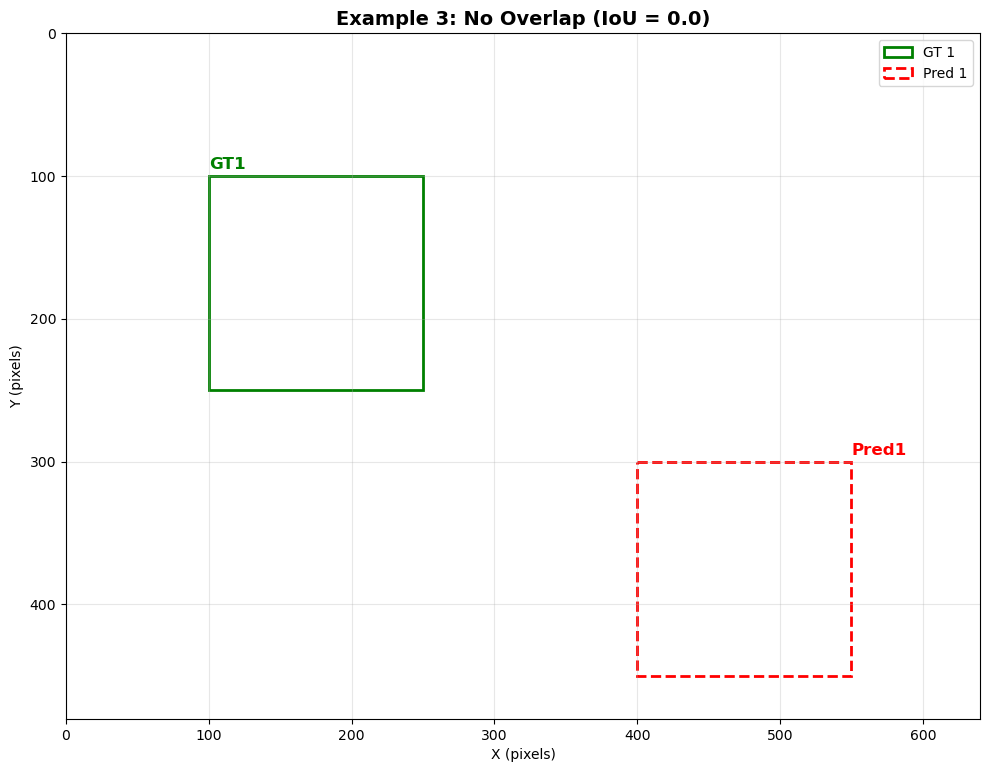

In [7]:
# Create annotations with no overlap
gt_anns_none = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 150, 150],
        "area": 150 * 150,
        "iscrowd": 0
    }
]

dt_anns_none = [
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [400, 300, 150, 150],  # Far away from GT
        "score": 0.75,
        "area": 150 * 150
    }
]

cocoGt_none, cocoDt_none = create_mock_coco_data(gt_anns_none, dt_anns_none)

cocoEval_none = COCOeval(cocoGt_none, cocoDt_none, iouType='bbox')
cocoEval_none.params.imgIds = [1]
cocoEval_none.params.catIds = [1]
cocoEval_none._prepare()

ious_none = cocoEval_none.computeIoU(imgId=1, catId=1)

print("\n" + "="*60)
print("EXAMPLE 3: NO OVERLAP")
print("="*60)
print("\nGround Truth Box: [x=100, y=100, w=150, h=150]")
print("Prediction Box:   [x=400, y=300, w=150, h=150]")
print_iou_matrix(ious_none)
print("\n✓ No overlap results in IoU = 0.0")

visualize_bboxes(
    gt_boxes=[[100, 100, 150, 150]],
    dt_boxes=[[400, 300, 150, 150]],
    title="Example 3: No Overlap (IoU = 0.0)"
)

## Example 4: Multiple Predictions vs Multiple Ground Truths

Computing IoU matrix for multiple detections and ground truths

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 4: MULTIPLE PREDICTIONS vs MULTIPLE GROUND TRUTHS

Ground Truth Boxes:
  GT1: [x=50,  y=50,  w=100, h=100]
  GT2: [x=300, y=200, w=120, h=80]
  GT3: [x=200, y=350, w=90,  h=90]

Prediction Boxes (sorted by score):
  Pred1: [x=55,  y=55,  w=95,  h=95]  score=0.92
  Pred2: [x=310, y=195, w=110, h=85]  score=0.88
  Pred3: [x=100, y=100, w=80,  h=80]  score=0.65

IoU Matrix:
               GT1       GT2       GT3
--------------------------------------
Pred1        0.902     0.000     0.000
Pred2        0.000     0.867     0.000
Pred3        0.180     0.000     0.000

Interpretation:
  • Pred1 matches best with GT1 (IoU ≈ 0.902)
  • Pred2 matches best with GT2 (IoU ≈ 0.867)
  • Pred3 has low IoU with all GTs (false positive or mislocalized)
  • GT3 has no good match (missed detection)


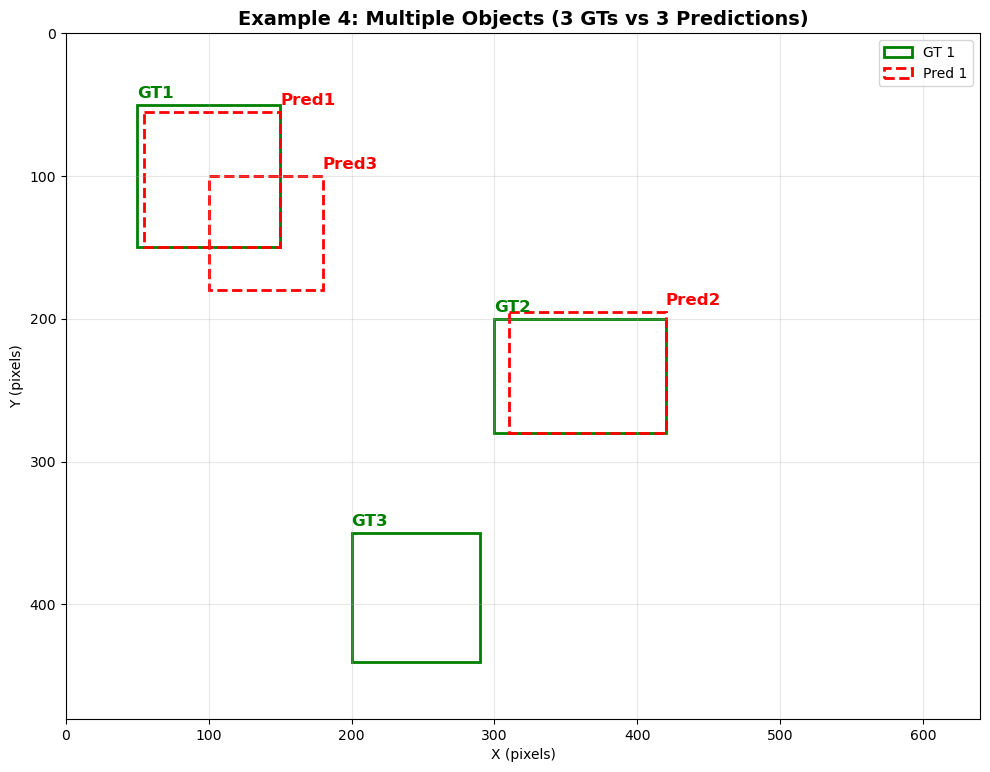

In [8]:
# Create annotations with multiple objects
gt_anns_multi = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "bbox": [50, 50, 100, 100],
        "area": 100 * 100,
        "iscrowd": 0
    },
    {
        "id": 2,
        "image_id": 1,
        "category_id": 1,
        "bbox": [300, 200, 120, 80],
        "area": 120 * 80,
        "iscrowd": 0
    },
    {
        "id": 3,
        "image_id": 1,
        "category_id": 1,
        "bbox": [200, 350, 90, 90],
        "area": 90 * 90,
        "iscrowd": 0
    }
]

dt_anns_multi = [
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [55, 55, 95, 95],  # Good match with GT1
        "score": 0.92,
        "area": 95 * 95
    },
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [310, 195, 110, 85],  # Good match with GT2
        "score": 0.88,
        "area": 110 * 85
    },
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 80, 80],  # Poor match, between GT1 and GT2
        "score": 0.65,
        "area": 80 * 80
    }
]

cocoGt_multi, cocoDt_multi = create_mock_coco_data(gt_anns_multi, dt_anns_multi)

cocoEval_multi = COCOeval(cocoGt_multi, cocoDt_multi, iouType='bbox')
cocoEval_multi.params.imgIds = [1]
cocoEval_multi.params.catIds = [1]
cocoEval_multi._prepare()

ious_multi = cocoEval_multi.computeIoU(imgId=1, catId=1)

print("\n" + "="*60)
print("EXAMPLE 4: MULTIPLE PREDICTIONS vs MULTIPLE GROUND TRUTHS")
print("="*60)
print("\nGround Truth Boxes:")
print("  GT1: [x=50,  y=50,  w=100, h=100]")
print("  GT2: [x=300, y=200, w=120, h=80]")
print("  GT3: [x=200, y=350, w=90,  h=90]")
print("\nPrediction Boxes (sorted by score):")
print("  Pred1: [x=55,  y=55,  w=95,  h=95]  score=0.92")
print("  Pred2: [x=310, y=195, w=110, h=85]  score=0.88")
print("  Pred3: [x=100, y=100, w=80,  h=80]  score=0.65")
print_iou_matrix(ious_multi, 
                gt_labels=["GT1", "GT2", "GT3"],
                dt_labels=["Pred1", "Pred2", "Pred3"])

print("\nInterpretation:")
print("  • Pred1 matches best with GT1 (IoU ≈ {:.3f})".format(ious_multi[0, 0]))
print("  • Pred2 matches best with GT2 (IoU ≈ {:.3f})".format(ious_multi[1, 1]))
print("  • Pred3 has low IoU with all GTs (false positive or mislocalized)")
print("  • GT3 has no good match (missed detection)")

visualize_bboxes(
    gt_boxes=[[50, 50, 100, 100], [300, 200, 120, 80], [200, 350, 90, 90]],
    dt_boxes=[[55, 55, 95, 95], [310, 195, 110, 85], [100, 100, 80, 80]],
    title="Example 4: Multiple Objects (3 GTs vs 3 Predictions)"
)

## Example 5: Segmentation Masks - Circular Shapes

Computing IoU for segmentation masks instead of bounding boxes. Masks provide pixel-level accuracy.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 5: SEGMENTATION MASKS - CIRCLES

Ground Truth: Circle at (250, 200) with radius 80
Prediction:   Circle at (260, 210) with radius 80
Offset: dx=10, dy=10 pixels

IoU Matrix:
               GT1
------------------
Pred1        0.798

✓ Slightly offset circles result in IoU ≈ 0.798
  Masks capture pixel-level overlap better than bboxes


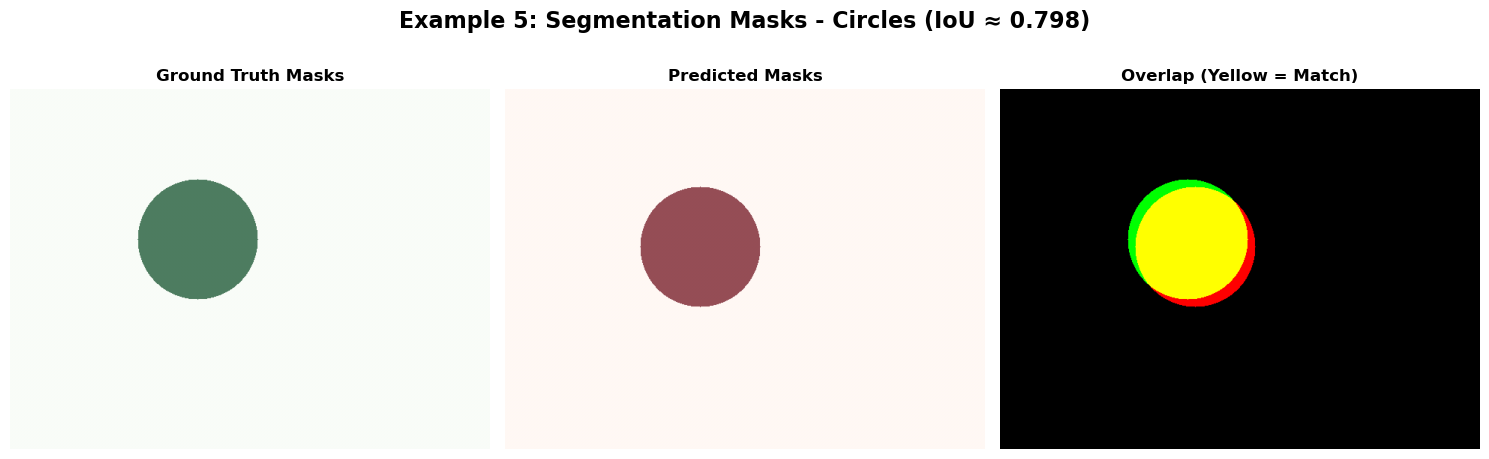

In [9]:
# Create simple binary masks - circles
img_size = (640, 480)

# Helper function to convert RLE to JSON-serializable format
def encode_mask(mask):
    rle = maskUtils.encode(np.asfortranarray(mask))
    rle['counts'] = rle['counts'].decode('utf-8')  # Convert bytes to string
    return rle

# Create ground truth mask - a circle
y, x = np.ogrid[:img_size[1], :img_size[0]]
center_y, center_x = 200, 250
radius = 80
gt_mask_circle = ((x - center_x)**2 + (y - center_y)**2 <= radius**2).astype(np.uint8)
gt_rle_circle = encode_mask(gt_mask_circle)

# Create prediction mask - slightly offset circle (good match)
center_y_pred, center_x_pred = 210, 260
dt_mask_circle = ((x - center_x_pred)**2 + (y - center_y_pred)**2 <= radius**2).astype(np.uint8)
dt_rle_circle = encode_mask(dt_mask_circle)

# Create annotations with segmentation masks
gt_anns_segm1 = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "segmentation": gt_rle_circle,
        "bbox": [center_x - radius, center_y - radius, 2*radius, 2*radius],
        "area": int(np.sum(gt_mask_circle)),
        "iscrowd": 0
    }
]

dt_anns_segm1 = [
    {
        "image_id": 1,
        "category_id": 1,
        "segmentation": dt_rle_circle,
        "bbox": [center_x_pred - radius, center_y_pred - radius, 2*radius, 2*radius],
        "score": 0.90,
        "area": int(np.sum(dt_mask_circle))
    }
]

cocoGt_segm1, cocoDt_segm1 = create_mock_coco_data(gt_anns_segm1, dt_anns_segm1, img_size=img_size)

cocoEval_segm1 = COCOeval(cocoGt_segm1, cocoDt_segm1, iouType='segm')
cocoEval_segm1.params.imgIds = [1]
cocoEval_segm1.params.catIds = [1]
cocoEval_segm1._prepare()

ious_segm1 = cocoEval_segm1.computeIoU(imgId=1, catId=1)

print("\n" + "="*60)
print("EXAMPLE 5: SEGMENTATION MASKS - CIRCLES")
print("="*60)
print("\nGround Truth: Circle at (250, 200) with radius 80")
print("Prediction:   Circle at (260, 210) with radius 80")
print(f"Offset: dx=10, dy=10 pixels")
print_iou_matrix(ious_segm1)
print(f"\n✓ Slightly offset circles result in IoU ≈ {ious_segm1[0,0]:.3f}")
print("  Masks capture pixel-level overlap better than bboxes")

visualize_masks(
    gt_masks=[gt_rle_circle],
    dt_masks=[dt_rle_circle],
    title=f"Example 5: Segmentation Masks - Circles (IoU ≈ {ious_segm1[0,0]:.3f})",
    img_size=img_size
)

## Example 6: Multiple Segmentations with useCats=False

Demonstrating category-agnostic evaluation where predictions are matched to ground truths purely based on IoU, ignoring category labels.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!

EXAMPLE 6: CATEGORY-AGNOSTIC EVALUATION (useCats=False)

Scenario: Good localization, but wrong category labels
----------------------------------------------------------------------
Ground Truth: GT1 (cat_1), GT2 (cat_2)
Predictions:  Pred1 (cat_2), Pred2 (cat_1)  ← Swapped!

IoU Matrix (ignoring categories):

IoU Matrix:
        GT1(cat_1)GT2(cat_2)
----------------------------
Pred1(cat_2)     0.853     0.000
Pred2(cat_1)     0.000     0.853

✓ IoU computed successfully despite category mismatch!
  • Pred1 matches GT1 with IoU ≈ 0.853
  • Pred2 matches GT2 with IoU ≈ 0.853

IoU Matrix (ignoring categories):

IoU Matrix:
        GT1(cat_1)GT2(cat_2)
----------------------------
Pred1(cat_2)     0.853     0.000
Pred2(cat_1)     0.000     0.853

✓ IoU computed successfully despite category mismatch!
  • Pred1 matches GT1 wi

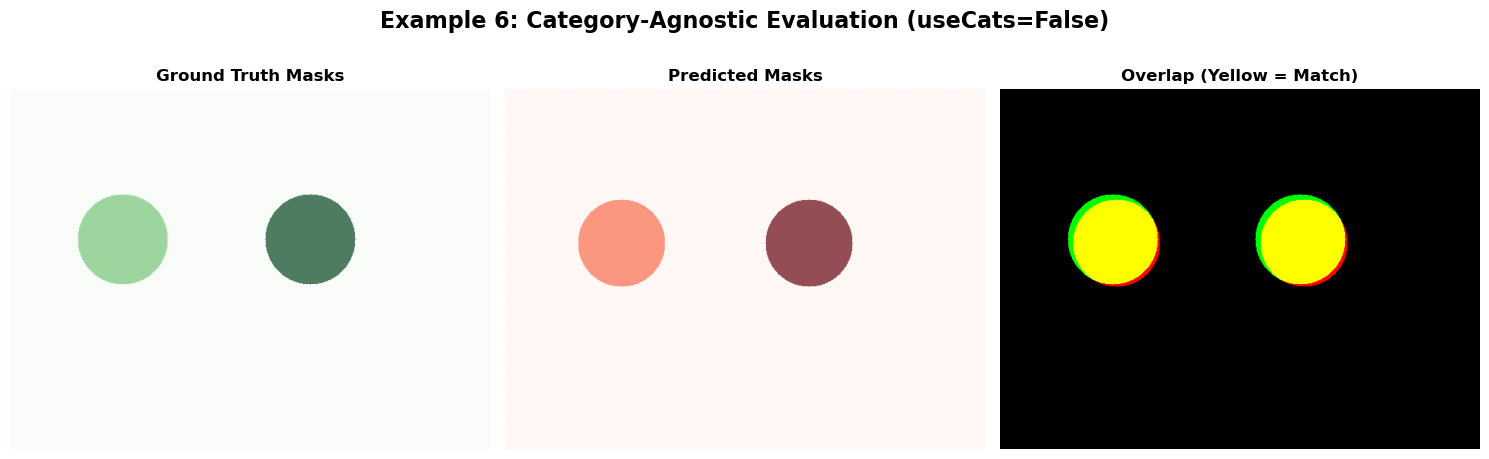


KEY POINT:
  useCats=False matches predictions to GTs based on IoU alone,
  ignoring category labels. Useful for evaluating localization
  quality independent of classification accuracy.


In [16]:
# Create simple segmentation masks with different categories
img_size = (640, 480)

# Helper function to create circular masks
def create_circle_mask(img_size, center_x, center_y, radius):
    y, x = np.ogrid[:img_size[1], :img_size[0]]
    mask = ((x - center_x)**2 + (y - center_y)**2 <= radius**2).astype(np.uint8)
    rle = maskUtils.encode(np.asfortranarray(mask))
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle, mask

# Ground truth: 2 circles with different categories
gt_circle1_rle, gt_circle1_mask = create_circle_mask(img_size, 150, 200, 60)
gt_circle2_rle, gt_circle2_mask = create_circle_mask(img_size, 400, 200, 60)

# Predictions: 2 circles well-localized but with DIFFERENT categories
dt_circle1_rle, dt_circle1_mask = create_circle_mask(img_size, 155, 205, 58)
dt_circle2_rle, dt_circle2_mask = create_circle_mask(img_size, 405, 205, 58)

# Ground truth annotations
gt_anns_multicat = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,  # Category 1
        "segmentation": gt_circle1_rle,
        "bbox": [90, 140, 120, 120],
        "area": int(np.sum(gt_circle1_mask)),
        "iscrowd": 0
    },
    {
        "id": 2,
        "image_id": 1,
        "category_id": 2,  # Category 2
        "segmentation": gt_circle2_rle,
        "bbox": [340, 140, 120, 120],
        "area": int(np.sum(gt_circle2_mask)),
        "iscrowd": 0
    }
]

# Predictions with swapped categories
dt_anns_multicat = [
    {
        "image_id": 1,
        "category_id": 2,  # Category 2 (WRONG - should be 1)
        "segmentation": dt_circle1_rle,
        "bbox": [97, 147, 116, 116],
        "score": 0.90,
        "area": int(np.sum(dt_circle1_mask))
    },
    {
        "image_id": 1,
        "category_id": 1,  # Category 1 (WRONG - should be 2)
        "segmentation": dt_circle2_rle,
        "bbox": [347, 147, 116, 116],
        "score": 0.88,
        "area": int(np.sum(dt_circle2_mask))
    }
]

# Create mock dataset
gt_dataset_multicat = {
    "info": {"description": "Mock COCO Dataset with Multiple Categories"},
    "images": [{"id": 1, "width": img_size[0], "height": img_size[1], "file_name": "mock_image.jpg"}],
    "categories": [
        {"id": 1, "name": "cat_1", "supercategory": "object"},
        {"id": 2, "name": "cat_2", "supercategory": "object"}
    ],
    "annotations": gt_anns_multicat
}

# Save to temp files
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    json.dump(gt_dataset_multicat, f)
    gt_file = f.name

with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
    json.dump(dt_anns_multicat, f)
    dt_file = f.name

# Create COCO objects
cocoGt_multicat = COCO(gt_file)
cocoDt_multicat = cocoGt_multicat.loadRes(dt_file)

# Clean up temp files
os.unlink(gt_file)
os.unlink(dt_file)

print("\n" + "="*70)
print("EXAMPLE 6: CATEGORY-AGNOSTIC EVALUATION (useCats=False)")
print("="*70)

print("\nScenario: Good localization, but wrong category labels")
print("-" * 70)
print("Ground Truth: GT1 (cat_1), GT2 (cat_2)")
print("Predictions:  Pred1 (cat_2), Pred2 (cat_1)  ← Swapped!")

# Evaluation WITHOUT categories (useCats=False)
cocoEval_no_cats = COCOeval(cocoGt_multicat, cocoDt_multicat, iouType='segm')
cocoEval_no_cats.params.imgIds = [1]
cocoEval_no_cats.params.useCats = 0  # Ignore categories
cocoEval_no_cats._prepare()

# With useCats=0, we use catId=-1 to get all annotations regardless of category
ious_no_cats = cocoEval_no_cats.computeIoU(imgId=1, catId=-1)

print("\nIoU Matrix (ignoring categories):")
print_iou_matrix(ious_no_cats, 
                gt_labels=["GT1(cat_1)", "GT2(cat_2)"],
                dt_labels=["Pred1(cat_2)", "Pred2(cat_1)"])

print("\n✓ IoU computed successfully despite category mismatch!")
print(f"  • Pred1 matches GT1 with IoU ≈ {ious_no_cats[0, 0]:.3f}")
print(f"  • Pred2 matches GT2 with IoU ≈ {ious_no_cats[1, 1]:.3f}")

# Visualize
visualize_masks(
    gt_masks=[gt_circle1_rle, gt_circle2_rle],
    dt_masks=[dt_circle1_rle, dt_circle2_rle],
    title="Example 6: Category-Agnostic Evaluation (useCats=False)",
    img_size=img_size
)

print("\n" + "="*70)
print("KEY POINT:")
print("  useCats=False matches predictions to GTs based on IoU alone,")
print("  ignoring category labels. Useful for evaluating localization")
print("  quality independent of classification accuracy.")
print("="*70)

## Deep Dive: IoU Thresholds and Confidence Scores

### 1. Multiple IoU Thresholds - Why They Matter

**What does it mean?**

COCO evaluation uses **multiple IoU thresholds** (0.50, 0.55, 0.60, ..., 0.95) to evaluate detection quality at different strictness levels.

**Why use multiple thresholds?**

Different applications have different requirements for localization accuracy:

- **IoU @ 0.5** ("PASCAL VOC metric"): 
  - Lenient - accepts predictions with 50% overlap
  - Good for: Initial detection, rough localization
  - A bbox that's "roughly in the right place" passes
  
- **IoU @ 0.75**:
  - Strict - requires 75% overlap
  - Good for: Applications needing precise localization
  - Example: Surgical planning, precise measurements
  
- **IoU @ 0.95**:
  - Very strict - requires near-perfect overlap
  - Rarely achieved in practice
  - Tests the upper limits of detection precision

**mAP (mean Average Precision)**:
COCO's primary metric averages AP across IoU thresholds from 0.5 to 0.95:
- **mAP@[.5:.95]**: Average over 10 thresholds (0.5, 0.55, ..., 0.95)
- **mAP@.50**: Only considers IoU ≥ 0.5 (easier, higher scores)
- **mAP@.75**: Only considers IoU ≥ 0.75 (harder, lower scores)

This multi-threshold approach rewards detectors that are both accurate at finding objects AND precise at localizing them.

In [10]:
# Demonstration: Same detection evaluated at different IoU thresholds
print("="*70)
print("DEMONSTRATION: IoU THRESHOLDS IN ACTION")
print("="*70)

# Use Example 2's partial overlap case (IoU ≈ 0.455)
iou_value = ious_partial[0, 0]

print(f"\nScenario: A prediction with IoU = {iou_value:.3f}")
print("\nEvaluation at different thresholds:")
print("-" * 70)

thresholds = [0.5, 0.75, 0.95]
for threshold in thresholds:
    if iou_value >= threshold:
        result = "✓ MATCH (True Positive)"
        explanation = "Detection is accepted"
    else:
        result = "✗ NO MATCH (False Positive)"
        explanation = "Detection is rejected - not precise enough"
    
    print(f"IoU Threshold @ {threshold:.2f}: {result:30s} - {explanation}")

print("\n" + "="*70)
print("KEY INSIGHT:")
print("The SAME prediction can be:")
print("  • A TRUE POSITIVE at lenient thresholds (IoU ≥ 0.5)")
print("  • A FALSE POSITIVE at strict thresholds (IoU ≥ 0.75)")
print("="*70)

DEMONSTRATION: IoU THRESHOLDS IN ACTION

Scenario: A prediction with IoU = 0.455

Evaluation at different thresholds:
----------------------------------------------------------------------
IoU Threshold @ 0.50: ✗ NO MATCH (False Positive)    - Detection is rejected - not precise enough
IoU Threshold @ 0.75: ✗ NO MATCH (False Positive)    - Detection is rejected - not precise enough
IoU Threshold @ 0.95: ✗ NO MATCH (False Positive)    - Detection is rejected - not precise enough

KEY INSIGHT:
The SAME prediction can be:
  • A TRUE POSITIVE at lenient thresholds (IoU ≥ 0.5)
  • A FALSE POSITIVE at strict thresholds (IoU ≥ 0.75)


### 2. Confidence Scores - The Ranking Mechanism

**What are confidence scores?**

Every prediction has a **confidence score** (typically 0.0 to 1.0) indicating how certain the model is that:
1. An object exists at that location
2. The object belongs to the predicted class

**Why do we use confidence scores?**

#### Purpose 1: Ranking Predictions

Predictions are **sorted by confidence score (descending)** before matching:

```python
# In computeIoU, predictions are sorted:
inds = np.argsort([-d['score'] for d in dt], kind='mergesort')
dt = [dt[i] for i in inds]
```

This ensures:
- High-confidence predictions are matched first
- Each ground truth can only match ONE prediction (highest confidence wins)
- Lower confidence predictions may become false positives

#### Purpose 2: Precision-Recall Trade-off

By varying the confidence threshold, we control the trade-off:

- **High confidence threshold (e.g., 0.9)**:
  - Fewer predictions accepted
  - Higher precision (fewer false positives)
  - Lower recall (more missed detections)
  - Use case: When false alarms are costly
  
- **Low confidence threshold (e.g., 0.3)**:
  - More predictions accepted
  - Lower precision (more false positives)
  - Higher recall (fewer missed detections)
  - Use case: When missing objects is costly

#### Purpose 3: Computing Average Precision (AP)

AP is computed by:
1. Sorting predictions by confidence (high to low)
2. For each confidence threshold, computing precision and recall
3. Plotting the precision-recall curve
4. Computing the area under this curve = Average Precision

This rewards models that:
- Assign high confidence to correct predictions (true positives)
- Assign low confidence to incorrect predictions (false positives)

In [11]:
# Demonstration: How confidence scores affect matching
print("="*70)
print("DEMONSTRATION: CONFIDENCE SCORES IN MATCHING")
print("="*70)

# Create a scenario with multiple predictions for same ground truth
print("\nScenario: 1 Ground Truth, 3 Predictions with different confidence")
print("-" * 70)

predictions = [
    {"id": "Pred_A", "score": 0.95, "iou": 0.85, "desc": "High confidence, good IoU"},
    {"id": "Pred_B", "score": 0.70, "iou": 0.90, "desc": "Medium confidence, better IoU"},
    {"id": "Pred_C", "score": 0.50, "iou": 0.75, "desc": "Low confidence, decent IoU"},
]

print("\nPredictions (before sorting):")
for i, pred in enumerate(predictions, 1):
    print(f"  {i}. {pred['id']}: score={pred['score']:.2f}, IoU={pred['iou']:.2f} - {pred['desc']}")

# Sort by confidence score (what COCO does)
predictions_sorted = sorted(predictions, key=lambda x: x['score'], reverse=True)

print("\nPredictions (after sorting by confidence - COCO's approach):")
for i, pred in enumerate(predictions_sorted, 1):
    print(f"  {i}. {pred['id']}: score={pred['score']:.2f}, IoU={pred['iou']:.2f}")

print("\n" + "="*70)
print("MATCHING PROCESS:")
print("="*70)
print(f"\n✓ {predictions_sorted[0]['id']} (highest confidence) MATCHES the ground truth")
print(f"✗ {predictions_sorted[1]['id']} becomes FALSE POSITIVE (GT already matched)")
print(f"✗ {predictions_sorted[2]['id']} becomes FALSE POSITIVE (GT already matched)")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("1. Higher confidence predictions get priority in matching")
print("2. Pred_B has better IoU (0.90) but loses to Pred_A's higher confidence")
print("3. Good confidence calibration is crucial - confidence should reflect accuracy")
print("4. This is why training includes confidence/objectness predictions")
print("="*70)

DEMONSTRATION: CONFIDENCE SCORES IN MATCHING

Scenario: 1 Ground Truth, 3 Predictions with different confidence
----------------------------------------------------------------------

Predictions (before sorting):
  1. Pred_A: score=0.95, IoU=0.85 - High confidence, good IoU
  2. Pred_B: score=0.70, IoU=0.90 - Medium confidence, better IoU
  3. Pred_C: score=0.50, IoU=0.75 - Low confidence, decent IoU

Predictions (after sorting by confidence - COCO's approach):
  1. Pred_A: score=0.95, IoU=0.85
  2. Pred_B: score=0.70, IoU=0.90
  3. Pred_C: score=0.50, IoU=0.75

MATCHING PROCESS:

✓ Pred_A (highest confidence) MATCHES the ground truth
✗ Pred_B becomes FALSE POSITIVE (GT already matched)
✗ Pred_C becomes FALSE POSITIVE (GT already matched)

KEY INSIGHTS:
1. Higher confidence predictions get priority in matching
2. Pred_B has better IoU (0.90) but loses to Pred_A's higher confidence
3. Good confidence calibration is crucial - confidence should reflect accuracy
4. This is why training in

### Putting It All Together: The Complete Evaluation Pipeline

Here's how IoU thresholds and confidence scores work together in COCO evaluation:

```
Step 1: For each IoU threshold (0.5, 0.55, ..., 0.95):
    
    Step 2: Sort predictions by confidence score (high to low)
    
    Step 3: For each prediction (in sorted order):
        - Compute IoU with all ground truths
        - If IoU ≥ threshold with any unmatched GT:
            → Mark as TRUE POSITIVE
            → Mark that GT as matched
        - Else:
            → Mark as FALSE POSITIVE
    
    Step 4: Unmatched GTs become FALSE NEGATIVES (missed detections)
    
    Step 5: Compute Precision-Recall curve from these matches
    
    Step 6: Compute Average Precision (area under PR curve)

Step 7: Average AP across all IoU thresholds → **mAP**
```

**Real-World Example:**

Imagine an autonomous vehicle detecting pedestrians:

1. **IoU Threshold = 0.5**: Must overlap 50% with actual pedestrian location
2. **IoU Threshold = 0.95**: Must nearly perfectly localize the pedestrian

The detector produces predictions like:
- Pedestrian at (100, 200), confidence=0.95
- Pedestrian at (110, 205), confidence=0.82  
- Pedestrian at (500, 300), confidence=0.45

**Evaluation process:**
1. Sort by confidence: [0.95, 0.82, 0.45]
2. Match highest confidence first
3. At IoU=0.5: More lenient, might accept all 3
4. At IoU=0.95: Very strict, might reject the last two
5. Average results across all thresholds

**Why this matters:**
- Safety-critical applications need high IoU thresholds
- Confidence helps prioritize which detections to trust
- mAP provides a single number summarizing performance across scenarios

In [12]:
# Visual summary using our earlier examples
print("="*70)
print("SUMMARY: Reviewing Examples Through This Lens")
print("="*70)

examples = [
    {"name": "Example 1 (Perfect Match)", "iou": ious_perfect[0,0], "confidence": 0.95},
    {"name": "Example 2 (Partial Overlap)", "iou": ious_partial[0,0], "confidence": 0.85},
    {"name": "Example 3 (No Overlap)", "iou": ious_none[0,0], "confidence": 0.75},
    {"name": "Example 5 (Segmentation)", "iou": ious_segm1[0,0], "confidence": 0.90},
]

print("\nHow each example performs at different IoU thresholds:")
print("-" * 70)
print(f"{'Example':<35} {'IoU':<10} {'@0.5':<8} {'@0.75':<8} {'@0.95':<8}")
print("-" * 70)

for ex in examples:
    iou = ex['iou']
    match_05 = "✓ TP" if iou >= 0.50 else "✗ FP"
    match_075 = "✓ TP" if iou >= 0.75 else "✗ FP"
    match_095 = "✓ TP" if iou >= 0.95 else "✗ FP"
    
    print(f"{ex['name']:<35} {iou:<10.3f} {match_05:<8} {match_075:<8} {match_095:<8}")

print("\n" + "="*70)
print("Notice how:")
print("  • Perfect Match (IoU=1.0) passes ALL thresholds")
print("  • Partial Overlap (IoU=0.45) fails ALL thresholds")
print("  • Segmentation (IoU=0.80) passes 0.5 and 0.75, fails 0.95")
print("\nThis is why mAP averages across thresholds - to reward both")
print("detection ability (finding objects) AND localization precision.")
print("="*70)

print("\n" + "="*70)
print("CONFIDENCE SCORES - Example 4 Revisited")
print("="*70)
print("\nIn Example 4, we had 3 predictions with scores: [0.92, 0.88, 0.65]")
print("\nThey were sorted by confidence BEFORE computing IoU:")
print("  1st: score=0.92 → matched to GT1 (IoU=0.90)")
print("  2nd: score=0.88 → matched to GT2 (IoU=0.87)")
print("  3rd: score=0.65 → no good match (becomes false positive)")
print("\nIf we had sorted by IoU instead (wrong approach):")
print("  1st: IoU=0.90 with GT1")
print("  2nd: IoU=0.87 with GT2")
print("  3rd: IoU=0.18 with GT1")
print("\nBut COCO uses confidence because:")
print("  • Models should be confident when they're correct")
print("  • It enables precision-recall trade-offs")
print("  • It reflects real-world deployment scenarios")
print("="*70)

SUMMARY: Reviewing Examples Through This Lens

How each example performs at different IoU thresholds:
----------------------------------------------------------------------
Example                             IoU        @0.5     @0.75    @0.95   
----------------------------------------------------------------------
Example 1 (Perfect Match)           1.000      ✓ TP     ✓ TP     ✓ TP    
Example 2 (Partial Overlap)         0.455      ✗ FP     ✗ FP     ✗ FP    
Example 3 (No Overlap)              0.000      ✗ FP     ✗ FP     ✗ FP    
Example 5 (Segmentation)            0.798      ✓ TP     ✓ TP     ✗ FP    

Notice how:
  • Perfect Match (IoU=1.0) passes ALL thresholds
  • Partial Overlap (IoU=0.45) fails ALL thresholds
  • Segmentation (IoU=0.80) passes 0.5 and 0.75, fails 0.95

This is why mAP averages across thresholds - to reward both
detection ability (finding objects) AND localization precision.

CONFIDENCE SCORES - Example 4 Revisited

In Example 4, we had 3 predictions with scor

## Understanding IoU Calculation

### Formula:

$$IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$

Where:
- **Area of Overlap** = Intersection of prediction and ground truth
- **Area of Union** = Union of prediction and ground truth

### Key Points:

1. **IoU Range**: Always between 0.0 and 1.0
   - 0.0 = No overlap
   - 1.0 = Perfect match

2. **COCO Evaluation**: Uses IoU thresholds from 0.5 to 0.95
   - IoU > 0.5 typically considered a "good" detection
   - IoU > 0.75 considered a "very good" detection

3. **Matching Strategy**:
   - Predictions are sorted by confidence score (descending)
   - Each prediction is matched to the ground truth with highest IoU
   - Each ground truth can only be matched once

4. **computeIoU Output**:
   - Returns an NxM matrix where:
     - N = number of predictions (sorted by score)
     - M = number of ground truths
   - Each element (i,j) contains IoU between prediction i and GT j

5. **BBox vs Segmentation**:
   - **Bounding Boxes**: Fast to compute, but includes empty space
   - **Segmentation Masks**: Pixel-level accuracy, better for irregular shapes
   - Segmentation typically gives lower IoU than bbox for same object
   - Masks are essential for instance segmentation tasks

## Example 9: Edge Cases

Testing edge cases with empty predictions or ground truths

In [13]:
print("\n" + "="*60)
print("EXAMPLE 9: EDGE CASES")
print("="*60)

# Case 1: No predictions
gt_anns_edge1 = [
    {
        "id": 1,
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 150, 150],
        "area": 150 * 150,
        "iscrowd": 0
    }
]

dt_anns_edge1 = []  # No predictions

cocoGt_edge1, cocoDt_edge1 = create_mock_coco_data(gt_anns_edge1, dt_anns_edge1)
cocoEval_edge1 = COCOeval(cocoGt_edge1, cocoDt_edge1, iouType='bbox')
cocoEval_edge1.params.imgIds = [1]
cocoEval_edge1.params.catIds = [1]
cocoEval_edge1._prepare()

ious_edge1 = cocoEval_edge1.computeIoU(imgId=1, catId=1)

print("\nCase 1: Ground Truth exists but NO predictions")
print(f"  Result: {ious_edge1}")
print(f"  Shape: {ious_edge1.shape if len(ious_edge1) > 0 else 'empty'}")
print("  → Empty array returned (all ground truths are missed detections)")

# Case 2: No ground truth
gt_anns_edge2 = []  # No ground truth

dt_anns_edge2 = [
    {
        "image_id": 1,
        "category_id": 1,
        "bbox": [100, 100, 150, 150],
        "score": 0.85,
        "area": 150 * 150
    }
]

cocoGt_edge2, cocoDt_edge2 = create_mock_coco_data(gt_anns_edge2, dt_anns_edge2)
cocoEval_edge2 = COCOeval(cocoGt_edge2, cocoDt_edge2, iouType='bbox')
cocoEval_edge2.params.imgIds = [1]
cocoEval_edge2.params.catIds = [1]
cocoEval_edge2._prepare()

ious_edge2 = cocoEval_edge2.computeIoU(imgId=1, catId=1)

print("\nCase 2: Prediction exists but NO ground truth")
print(f"  Result: {ious_edge2}")
print(f"  Shape: {ious_edge2.shape if len(ious_edge2) > 0 else 'empty'}")
print("  → Empty array returned (all predictions are false positives)")

# Case 3: Both empty
gt_anns_edge3 = []
dt_anns_edge3 = []

cocoGt_edge3, cocoDt_edge3 = create_mock_coco_data(gt_anns_edge3, dt_anns_edge3)
cocoEval_edge3 = COCOeval(cocoGt_edge3, cocoDt_edge3, iouType='bbox')
cocoEval_edge3.params.imgIds = [1]
cocoEval_edge3.params.catIds = [1]
cocoEval_edge3._prepare()

ious_edge3 = cocoEval_edge3.computeIoU(imgId=1, catId=1)

print("\nCase 3: NO ground truth AND NO predictions")
print(f"  Result: {ious_edge3}")
print(f"  Shape: {ious_edge3.shape if len(ious_edge3) > 0 else 'empty'}")
print("  → Empty array returned (nothing to evaluate)")

print("\n" + "="*60)


EXAMPLE 9: EDGE CASES
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...


IndexError: list index out of range

## Summary

This notebook demonstrated the `computeIoU` method comprehensively:

### Bounding Box Examples (Examples 1-4):
1. **Perfect Match**: IoU = 1.0 when prediction exactly matches ground truth
2. **Partial Overlap**: IoU values between 0 and 1 based on overlap degree
3. **No Overlap**: IoU = 0.0 when boxes don't intersect
4. **Multiple Objects**: IoU matrix for many-to-many matching scenarios

### Segmentation Examples (Examples 5-8):
5. **Circular Masks**: Pixel-level accuracy with offset circles
6. **Rectangular Masks**: Perfect segmentation match demonstration
7. **Irregular L-Shapes**: Shows advantage of masks over bboxes for complex shapes
8. **Multiple Masks**: IoU matrix for multiple segmentation instances

### Edge Cases (Example 9):
- Handling empty predictions (missed detections)
- Handling empty ground truths (false positives)
- Both empty (no evaluation needed)

### Key Takeaways:

**The `computeIoU` method is fundamental to COCO evaluation:**
- ✓ Matches predictions to ground truths based on overlap
- ✓ Supports both bounding boxes (`iouType='bbox'`) and segmentation masks (`iouType='segm'`)
- ✓ Returns an NxM matrix (N predictions × M ground truths)
- ✓ Predictions are sorted by confidence score before matching
- ✓ Handles edge cases gracefully with empty arrays

**When to use each type:**
- **Bounding Boxes**: Faster, good for rectangular objects, simpler annotation
- **Segmentation Masks**: More accurate, essential for irregular shapes, pixel-level precision

**Practical Applications:**
- Computing precision and recall at different IoU thresholds (0.5, 0.75, 0.95)
- Evaluating detection quality across different overlap criteria
- Matching predicted instances to ground truth for evaluation metrics